# Question 1

Use Sklearn Library to train Decision Trees. [1.5 marks]

1. Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.
2. Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.
3. Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.
4. Compare the results of the three models. Which model do you think is better?


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import tsfel
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

### Model 1: Using raw accelerometer data


By raw accelerometer data, we mean the data that was generated by running CombineSCript.py and MakeDataset.py.
Since the shape of that dataset is (126, 500, 3) (which means, 126 samples, each containing 3 columns of accx, accy, accz and 500 time stamp rows), to feed it in the Decision Tree Model, we need a 2D array. There are two ways to tackle this, either flatten the 500 x 3 structure into 1500 x 1 and then get 126, 1500 data or shrink the 3 columns into 1 by taking sum of their squares (total acceleration). The second approach seems more intuitive and hence, we have selected that.

Extracting the dataset form the Combined folder.

In [158]:
time = 10 # Setting the time window for each sample
offset = 100 # Skipping the first 100 rows to remove noise
folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

combined_dir = os.path.join("../Combined")

X_train=[]
y_train=[]
dataset_dir = os.path.join(combined_dir,"Train")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))

    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_train.append(df.values)
        y_train.append(classes[folder])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test=[]
y_test=[]
dataset_dir = os.path.join(combined_dir,"Test")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))
    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_test.append(df.values)
        y_test.append(classes[folder])

X_test = np.array(X_test)
y_test = np.array(y_test)

# USE THE BELOW GIVEN DATA FOR TRAINING and TESTING purposes

# concatenate the training and testing data
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))

# split the data into training and testing sets. Change the seed value to obtain different random splits.
seed = 4
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=seed,stratify=y)

print("Training data shape: ", X_train.shape) # (number of samples, number of time steps (x (=10) sec * 50Hz), number of features)
print("Testing data shape: ", X_test.shape)
print("Training labels shape: ", y_train.shape)
print("Testing labels shape: ", y_test.shape)

# Data - 3D array of 180 samples
# Splitting 180 samples into 70% training and 30% testing data so 126 samples for training and 54 samples for testing
# 126 / 6 = 21 meaning 21 samples per activity
# 500 = 10 * 50 meaning 500 time steps per sample as 10 seconds of data is collected at 50Hz
# 3 signifies the number of features (x, y, z) for each time step

# Labels - 1D array of 180 labels
# 126 means 126 labels for the training data according to the corresponding activity
# 54 means 54 labels for the testing data according to the corresponding activity

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)
Training labels shape:  (126,)
Testing labels shape:  (54,)


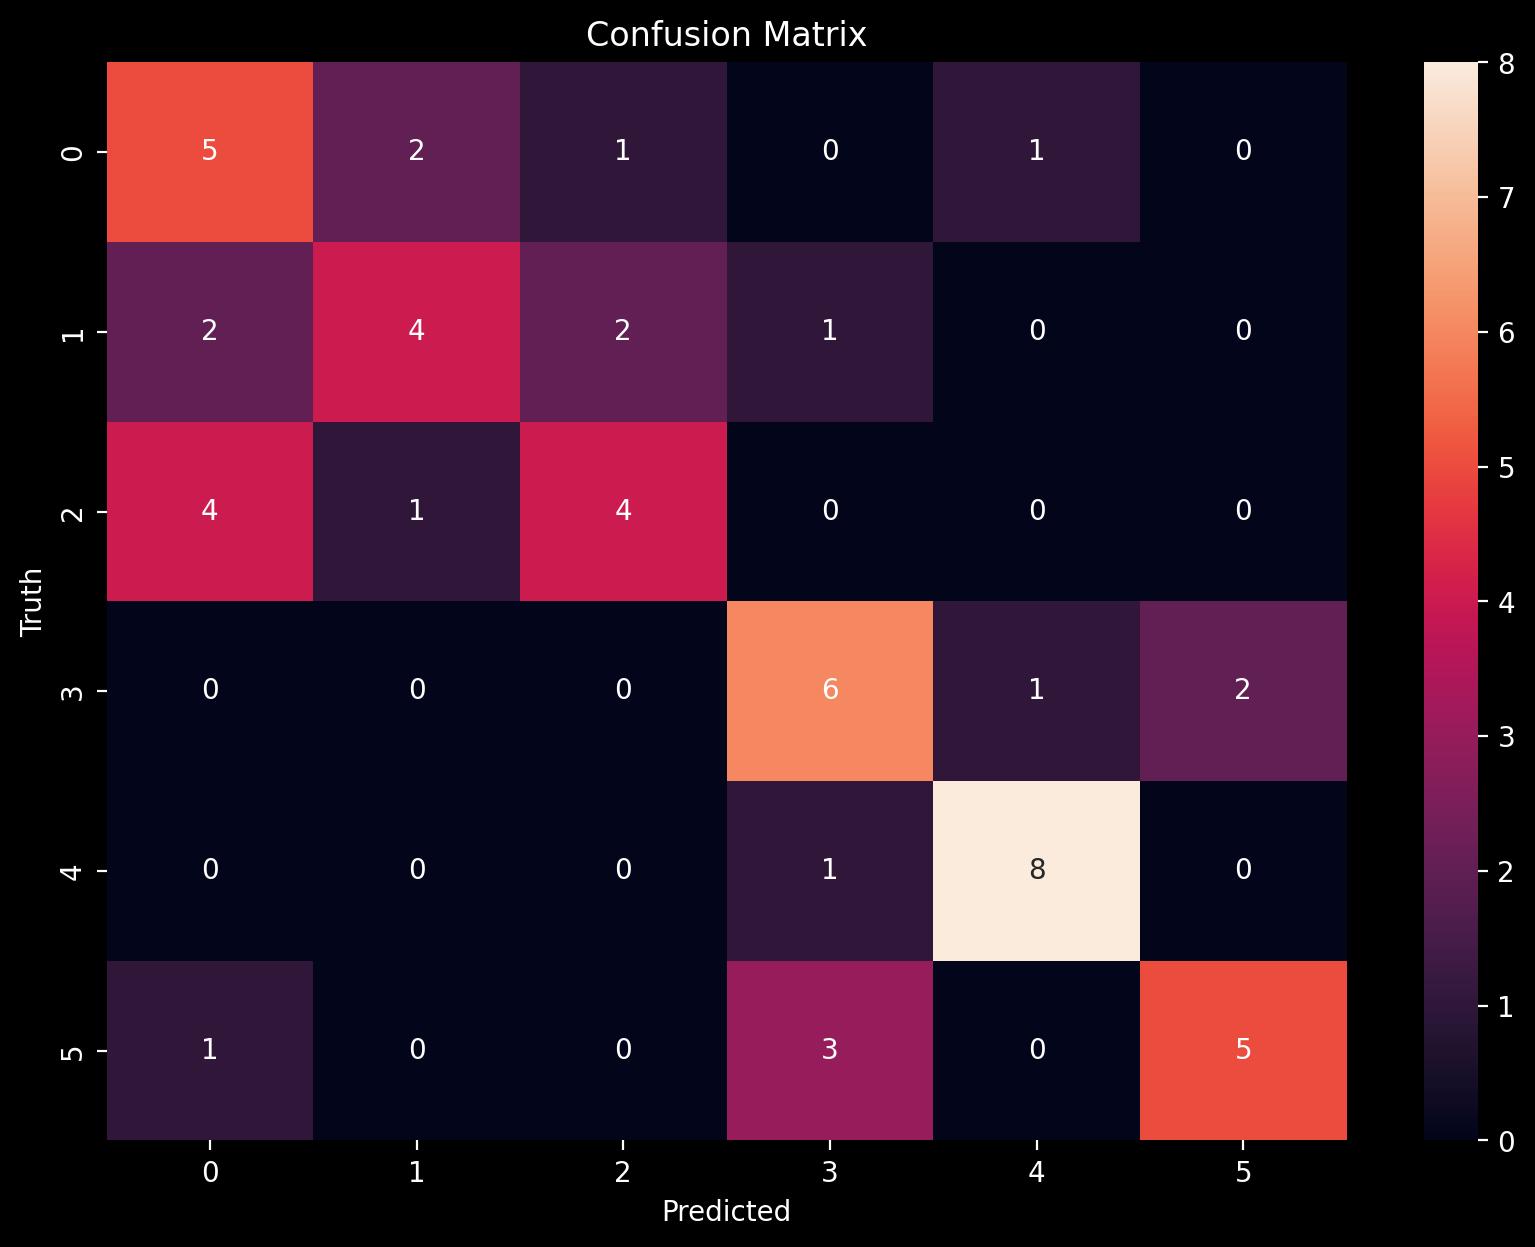

Provided Dataset Accuracy: 0.5925925925925926
Provided Dataset Precision: 0.6032106782106782
Provided Dataset Recall: 0.5925925925925926

Provided Dataset Confusion Matrix:
[[5 2 1 0 1 0]
 [2 4 2 1 0 0]
 [4 1 4 0 0 0]
 [0 0 0 6 1 2]
 [0 0 0 1 8 0]
 [1 0 0 3 0 5]]


In [159]:
# taking the square root of the sum of squares of the x, y, z values for each time step to get the magnitude of the acceleration
# this makes the size of the train data as 126, 500

X_train_reshaped = np.sum(X_train**2, axis=2)
X_test_reshaped = np.sum(X_test**2, axis=2)

# ! this is the other approach, both give nearly the same accuracy
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# train the decision tree classifier
dtc_dataset = DecisionTreeClassifier()
dtc_dataset.fit(X_train_reshaped, y_train)
y_pred_dataset = dtc_dataset.predict(X_test_reshaped)
acc_dataset = accuracy_score(y_test, y_pred_dataset)

# since, this model is using the provided dataset which is balanced, we will use macro average for precision and rec_dataset
# balanced dataset means that the number of samples for each class is equal
prec_dataset = precision_score(y_test, y_pred_dataset, average='macro')
rec_dataset = recall_score(y_test, y_pred_dataset, average='macro')

# normal confusion matrix
conf_mx_dataset = confusion_matrix(y_test, y_pred_dataset)

# confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_mx_dataset, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

print("Provided Dataset Accuracy:", acc_dataset)
print("Provided Dataset Precision:", prec_dataset)
print("Provided Dataset Recall:", rec_dataset)
print()
print("Provided Dataset Confusion Matrix:")
print(conf_mx_dataset)

### Model 2: Using features obtained by TSFEL


##### Just for the sake of understanding:

TSFEL - Time Series Feature Extraction Library is a Python package specifically designed to automate the process of extracting meaningful features from time series data.

It's main advantages are:

1. Extracting meaningful and relevant features using pre-defined feature extraction functions.
2. Wide variety of features that help in exploring different characteristics.
3. Helps in discovering hidden patterns or relationships that might not be apparent from the raw readings alone.
4. By providing a broader set of potentially informative features, TSFEL can help machine learning models achieve better performance compared to using only the raw data.


In [160]:
# the TSFEL library expects the data in pandas dataframe format where each column represents a time series and each row represents a time step
X_train_dfs = []

for sample in X_train:
  df = pd.DataFrame(sample, columns=["accx", "accy", "accz"])
  reshaped_df = pd.DataFrame(np.sum(sample**2, axis=1), columns=["magnitude"])
  X_train_dfs.append(reshaped_df)

X_test_dfs = []

for sample in X_test:
  df = pd.DataFrame(sample, columns=["accx", "accy", "accz"])
  reshaped_df = pd.DataFrame(np.sum(sample**2, axis=1), columns=["magnitude"])
  X_test_dfs.append(reshaped_df)

# we will be using the default tsfel configuration for the features
# this is a dictionary that specifies a wide range of features to be extracted across different domains (statistical, temporal, spectral, etc.).
tsfel_config = tsfel.get_features_by_domain()
# print(len(tsfel_config["spectral"]) + len(tsfel_config["fractal"]) + len(tsfel_config["statistical"]) + len(tsfel_config["temporal"]))
# ? This gives 67

# extract features for X_train
# iterating over each sample to characterize its unique features
# if we combine all our samples into a single dataframe and then extract features, TSFEL might interpret the entire concatenated time series as a single entity. This could lead to features being calculated across different activities, which might not be meaningful or useful for our classification task.
# since our accelerometer data is sampled at 50Hz, we need to tell TSFEL that the sampling frequency is 50Hz so that when it calculates features that depend on time, it can use the correct time intervals.
# TSFEL uses FFT to calculate the spectral features and hence requires the sampling frequency to be the same as the actual sampling frequency of the data.
# we haven't mentioned overlap and window_size as the data which we are using is already windowed and has no overlap.
# according to the TSFEL documentation, if we have access to the actual sampling frequency, we should provide it to the library as a good practice.
X_train_tsfel_dfs = []
for df in X_train_dfs:
    feature_df = tsfel.time_series_features_extractor(tsfel_config, df, fs=50)
    X_train_tsfel_dfs.append(feature_df)
# the output of tsfel.time_series_features_extractor(tsfel_config, df, fs=50) is a pandas dataframe containing the extracted features where each row represents a sample and each column represents a feature as specified in the tsfel_config dictionary.
# ? Here each dataframe is of size 1 x (3 * 384) = 1 x 1152

# convert the list of feature dataframe back to a numpy array
# since we have 126 samples and each sample has 1152 features, the shape of the array should be (126, 1152)
# there are some NaN values because some features are not applicable to the data and hence are not calculated
# fill NaN values with 0 to ensure the array is compatible with scikit-learn
X_train_tsfel = pd.concat(X_train_tsfel_dfs, axis=0).fillna(0).values

# same for X_test
X_test_tsfel_dfs = []
for df in X_test_dfs:
    feature_df = tsfel.time_series_features_extractor(tsfel_config, df, fs=50)
    X_test_tsfel_dfs.append(feature_df)
# since we have 54 samples and each sample has 1152 features, the shape of the array should be (54, 1152)
X_test_tsfel = pd.concat(X_test_tsfel_dfs, axis=0).fillna(0).values

# since many columns are constant throughout all samples, we can remove them and some columns are highly correlated, we can remove them as well because they don't provide any additional information
# ========================================================================================================================
# merge the list of dataframes into a single dataframe
col = X_train_tsfel_dfs[0].columns
X_train_tsfel_df = pd.DataFrame(X_train_tsfel, columns=col)
X_test_tsfel_df = pd.DataFrame(X_test_tsfel, columns=col)

# do the following for the training data and then choose remaining columns from the test data
# remove columns where the feature is constant throughout all samples
for col in X_train_tsfel_df.columns:
    if len(X_train_tsfel_df[col].unique()) == 1:
        X_train_tsfel_df.drop(col, axis=1, inplace=True)

# remove highly correlated features (columns) from the training data which have a correlation greater than 0.9
corr = X_train_tsfel_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
tri_df = corr.mask(mask)
to_drop = [c for c in tri_df.columns if any(
    tri_df[c] > 0.9)]  # threshold = 0.9
X_train_tsfel_df.drop(columns=to_drop, inplace=True)

# remove the same columns from the test data
X_test_tsfel_df = X_test_tsfel_df[X_train_tsfel_df.columns]

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


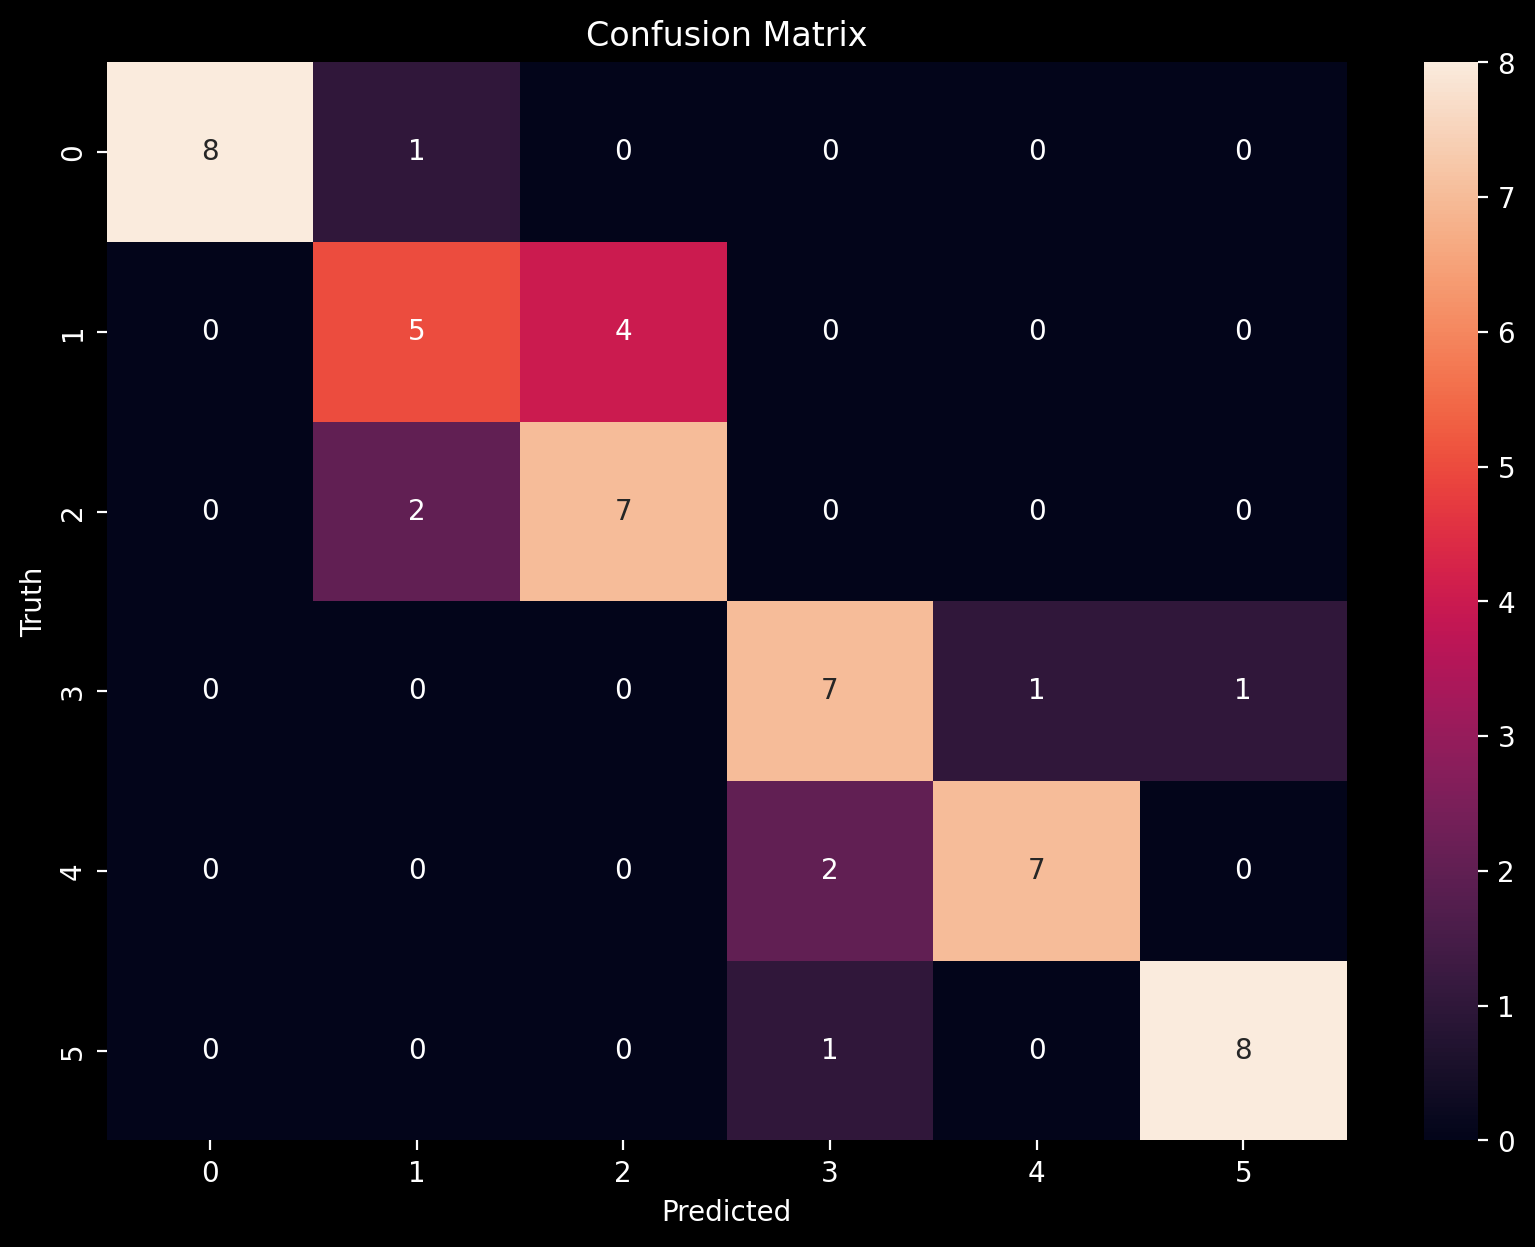

TSFEL Accuracy: 0.7777777777777778
TSFEL Precision: 0.7875420875420875
TSFEL Recall: 0.7777777777777777

TSFEL Confusion Matrix:
[[8 1 0 0 0 0]
 [0 5 4 0 0 0]
 [0 2 7 0 0 0]
 [0 0 0 7 1 1]
 [0 0 0 2 7 0]
 [0 0 0 1 0 8]]


In [161]:
X_train_tsfel_values = X_train_tsfel_df.values
X_test_tsfel_values = X_test_tsfel_df.values

dtc_tsfel = DecisionTreeClassifier()
dtc_tsfel.fit(X_train_tsfel_values, y_train)
y_pred_tsfel = dtc_tsfel.predict(X_test_tsfel_values)
acc_tsfel = accuracy_score(y_test, y_pred_tsfel)

# Since, this model is using the provided dataset which is balanced, we will use macro average for precision and recall
prec_tsfel = precision_score(y_test, y_pred_tsfel, average='macro')
rec_tsfel = recall_score(y_test, y_pred_tsfel, average='macro')

# normal confusion matrix
conf_mx_tsfel = confusion_matrix(y_test, y_pred_tsfel)

# confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_mx_tsfel, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

print("TSFEL Accuracy:", acc_tsfel)
print("TSFEL Precision:", prec_tsfel)
print("TSFEL Recall:", rec_tsfel)
print()
print("TSFEL Confusion Matrix:")
print(conf_mx_tsfel)

#### Model 3: Using processed dataset provided by the author which contains 561 features


/var/folders/zs/jphm90712636hwjl914hl1v80000gn/T/ipykernel_78835/752507593.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_561 = pd.read_csv(os.path.join(raw_data_dir, "train", "X_train.txt"), delim_whitespace=True, header=None)
/var/folders/zs/jphm90712636hwjl914hl1v80000gn/T/ipykernel_78835/752507593.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_561 = pd.read_csv(os.path.join(raw_data_dir, "test", "X_test.txt"), delim_whitespace=True, header=None)


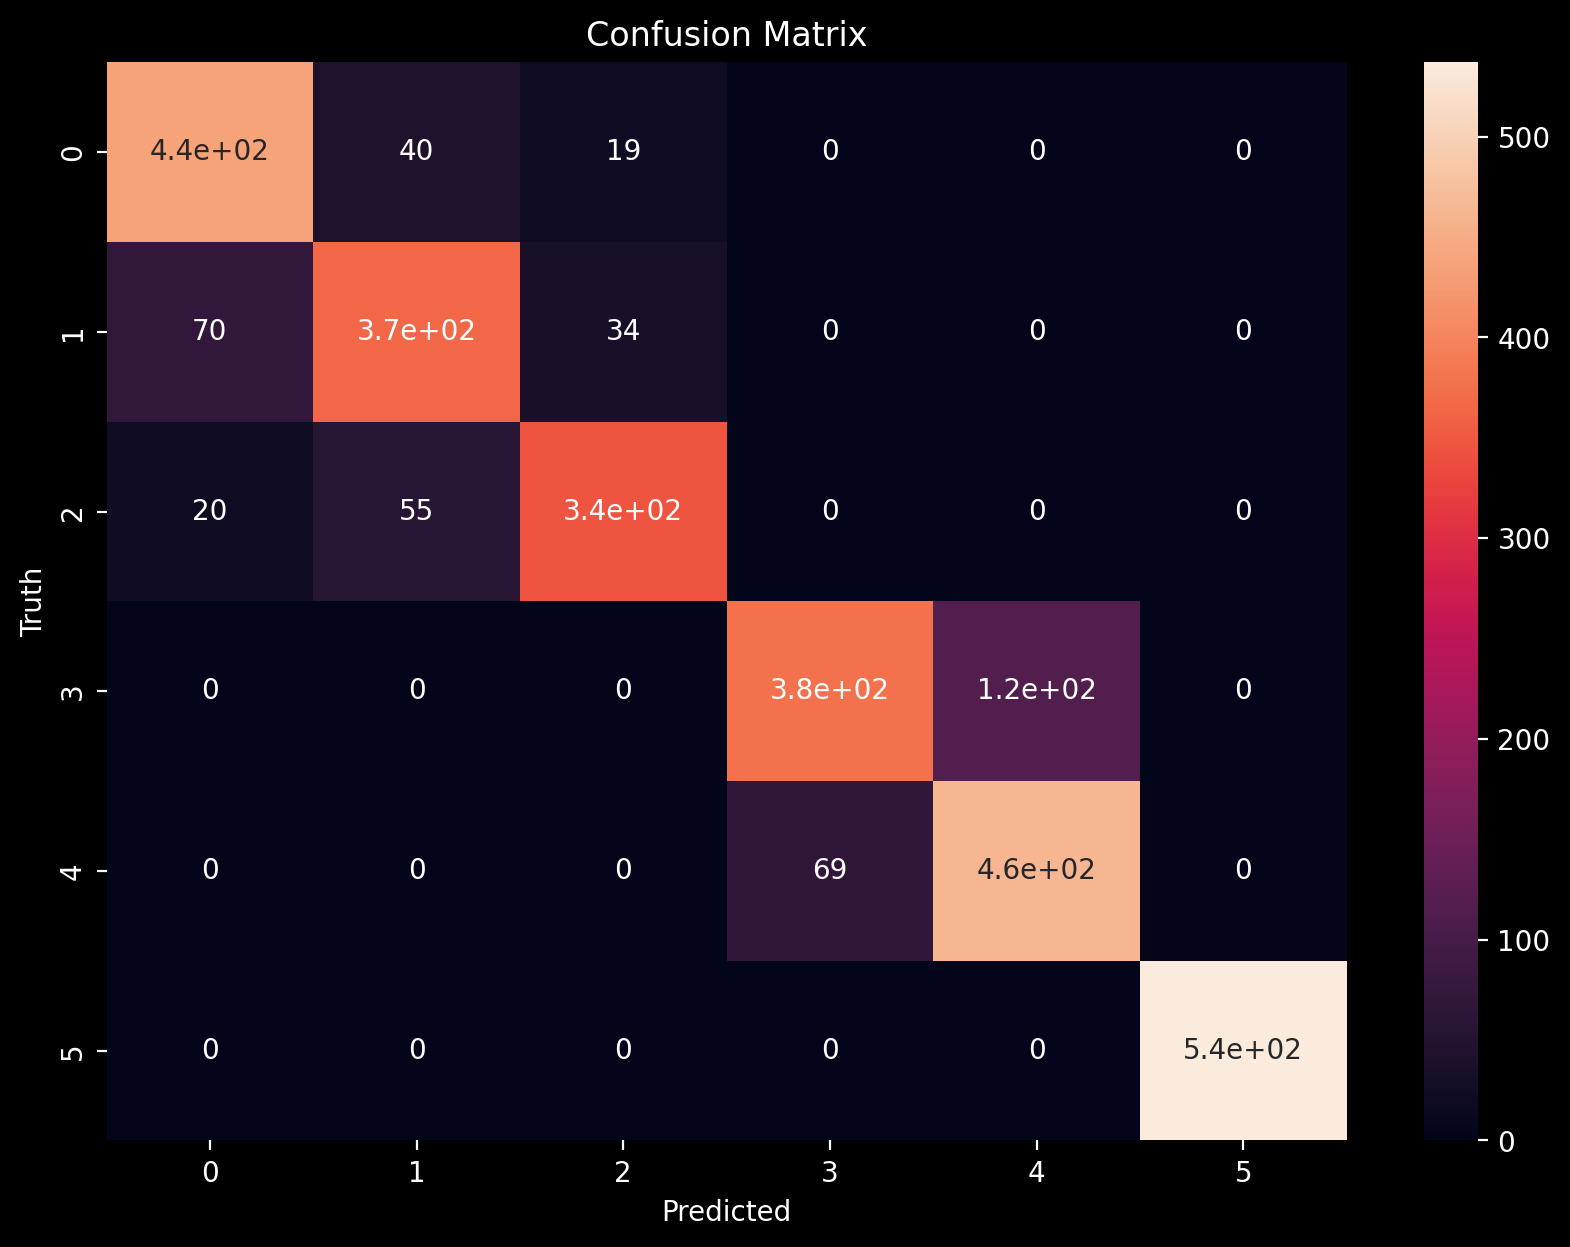

561 Dataset Accuracy: 0.8568035290125552
561 Dataset Precision: 0.8576632117137729
561 Dataset Recall: 0.8568035290125552

561 Dataset Confusion Matrix:
[[437  40  19   0   0   0]
 [ 70 367  34   0   0   0]
 [ 20  55 345   0   0   0]
 [  0   0   0 376 115   0]
 [  0   0   0  69 463   0]
 [  0   0   0   0   0 537]]


In [162]:
raw_data_dir = '../HAR/UCI HAR Dataset'

X_train_561 = pd.read_csv(os.path.join(raw_data_dir, "train", "X_train.txt"), delim_whitespace=True, header=None)
X_test_561 = pd.read_csv(os.path.join(raw_data_dir, "test", "X_test.txt"), delim_whitespace=True, header=None)

y_train_561 = pd.read_csv(os.path.join(raw_data_dir, "train", "y_train.txt"), header=None)
y_test_561 = pd.read_csv(os.path.join(raw_data_dir, "test", "y_test.txt"), header=None)

# now train the decision tree classifier
dtc_561 = DecisionTreeClassifier()
dtc_561.fit(X_train_561, y_train_561)
y_pred_561 = dtc_561.predict(X_test_561)
acc_561 = accuracy_score(y_test_561, y_pred_561)

# since, this model is using the provided dataset which is imbalanced, we will use weighted average for precision and recall
prec_561 = precision_score(y_test_561, y_pred_561, average='weighted')
rec_561 = recall_score(y_test_561, y_pred_561, average='weighted')

# normal confusion matrix
conf_mx_561 = confusion_matrix(y_test_561, y_pred_561)

# confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_mx_561, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Print the results
print("561 Dataset Accuracy:", acc_561)
print("561 Dataset Precision:", prec_561)
print("561 Dataset Recall:", rec_561)
print()
print("561 Dataset Confusion Matrix:")
print(conf_mx_561)

# Verdict for Question 1

The best model is the one trained on the dataset provided by the author which contains 561 features. Then comes the model trained on the dataset containing features extracted from TSFEL. The worst performing model is the one trained on raw data.

Accuracy: Provided Dataset > TSFEL > Raw Accelerometer Data

Here is our understanding of why this is happening:
1. TSFEL is better than raw data as TSFEL extracts meaningful features from the raw dataset which provides additional information which wasn't previously evident to the model leading to better classification. 
2. The model trained on the dataset provided by the author has way more features than what TSFEL provided which are more specific as they are obtained from the 128 samples sliding window instead of getting them directly from the 500 row data (more feature vectors per sample), hence again there is additional information available for the model which leads to better accuracy. 

# Question 2

Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. [1 marks]


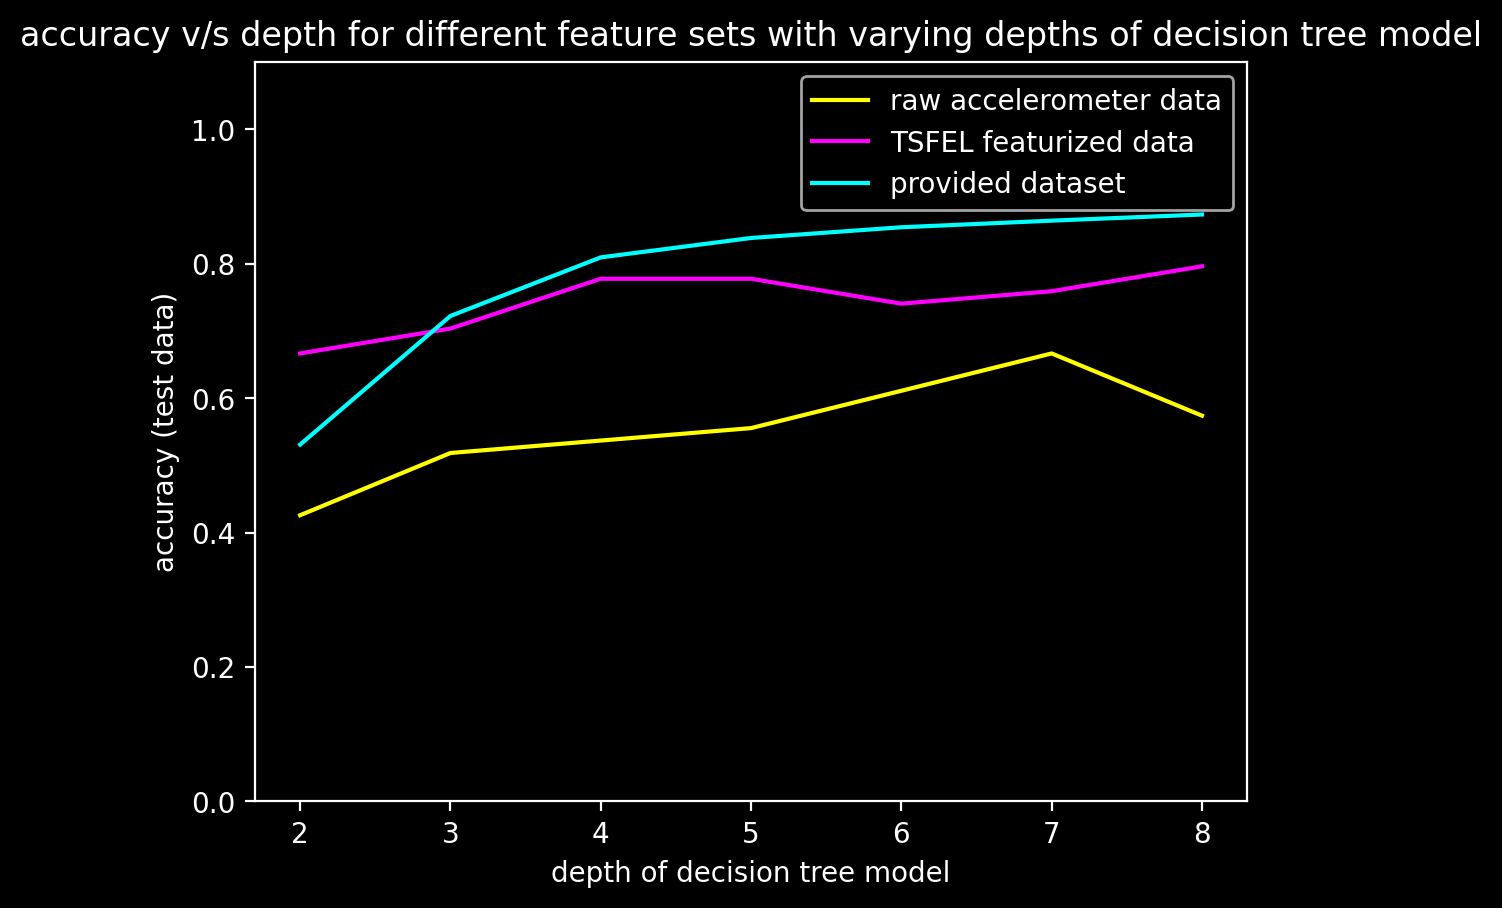

In [165]:
# define lists to store accuracy scores for all three feature sets
acc_scores_raw = []
acc_scores_tsfel = []
acc_scores_dataset = []

depths = range(2, 9)

# raw accelerometer data
for depth in depths:
    dtf_raw = DecisionTreeClassifier(max_depth=depth)
    dtf_raw.fit(X_train_reshaped, y_train)
    y_pred_raw = dtf_raw.predict(X_test_reshaped)
    acc_raw = accuracy_score(y_test, y_pred_raw)
    acc_scores_raw.append(acc_raw)

# TSFEL
for depth in depths:
    dtf_tsfel = DecisionTreeClassifier(max_depth=depth)
    dtf_tsfel.fit(X_train_tsfel_values, y_train)
    y_pred_tsfel = dtf_tsfel.predict(X_test_tsfel_values)
    acc_tsfel = accuracy_score(y_test, y_pred_tsfel)
    acc_scores_tsfel.append(acc_tsfel)

# provided dataset
for depth in depths:
    dtf_dataset = DecisionTreeClassifier(max_depth=depth)
    dtf_dataset.fit(X_train_561, y_train_561)
    y_pred_dataset = dtf_dataset.predict(X_test_561)
    acc_dataset = accuracy_score(y_test_561, y_pred_dataset)
    acc_scores_dataset.append(acc_dataset)

# plot the accuracy scores
plt.plot(depths, acc_scores_raw, label='raw accelerometer data', color="yellow")
plt.plot(depths, acc_scores_tsfel, label='TSFEL featurized data', color="magenta")
plt.plot(depths, acc_scores_dataset, label='provided dataset', color="cyan")
plt.xlabel('depth of decision tree model')
plt.ylabel('accuracy (test data)')
plt.ylim(0, 1.1)
plt.title('accuracy v/s depth for different feature sets with varying depths of decision tree model')
plt.legend()
plt.show()

# Question 3

Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]


First, let's check for activities.


We will use the TSFEL model with depth = 8 to see if there are any participants / activities where the model is performing poorly.

A low precision means many false positives.

A low recall means many false negatives.

Precision is low for a certain activity, it means the model frequently misclassifies other activities as this one.

Recall is low for a certain activity, it means the model misses many instances of this activity.

F1 score is the harmonic mean of precision and recall so it would be a good factor to judge the model for each activity.


In [173]:
activities = {1: "WALKING", 2: "WALKING UPSTAIRS", 3: "WALKING DOWNSTAIRS", 4: "SITTING", 5: "STANDING", 6: "LAYING"}

# set average=None to get precision, recall, and F1 score for each class
prec_per_act = precision_score(y_test, y_pred_tsfel, average=None, labels=list(activities.keys()))
rec_per_act = recall_score(y_test, y_pred_tsfel, average=None, labels=list(activities.keys()))
f1_per_act = f1_score(y_test, y_pred_tsfel, average=None, labels=list(activities.keys()))

for i, (prec, rec, f1) in enumerate(zip(prec_per_act, rec_per_act, f1_per_act)):
    act_name = activities.get(i + 1)
    print(act_name)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 score:", f1)
    print()

WALKING
Precision: 1.0
Recall: 0.8888888888888888
F1 score: 0.9411764705882353

WALKING UPSTAIRS
Precision: 0.6666666666666666
Recall: 0.8888888888888888
F1 score: 0.7619047619047619

WALKING DOWNSTAIRS
Precision: 0.8571428571428571
Recall: 0.6666666666666666
F1 score: 0.75

SITTING
Precision: 0.6363636363636364
Recall: 0.7777777777777778
F1 score: 0.7

STANDING
Precision: 0.875
Recall: 0.7777777777777778
F1 score: 0.8235294117647058

LAYING
Precision: 0.875
Recall: 0.7777777777777778
F1 score: 0.8235294117647058



From this, we can see that the activity "Walking Upstairs" and "Walking Downstairs" have the worst f1 score. This may be because the movements involved in walking upstairs and downstairs can be quite similar in terms of acceleration patterns, both are rhythmic, repetitive motion, making it harder for the classifier to distinguish between them based on accelerometer data.